In [200]:
import pandas as pd

data = pd.read_csv("Larger_Activities.csv")
# Need to clean data first.  
# First just want to start on June 1 then until October 1
# Then drop uncessary columns
# Turn strings into numbers


In [201]:
#Fixing the date problems
data["Date"] = pd.to_datetime(data["Date"])
data = data[(data["Date"].dt.month >= 6) & (data["Date"].dt.month < 10)]


In [202]:
#Adding weekday and week columns
data["Weekday"] = data["Date"].dt.day_name()

# To get accurate week numbers for each data set
data["Week_Start"] = data["Date"].dt.to_period("W-SUN").apply(lambda r: r.start_time)
data["Week"] = data["Week_Start"].rank(method="dense").astype(int)


#Dropping columns
data = data[["Date", "Week", "Weekday", "Distance", "Calories", "Time", "Avg HR", "Max HR", "Avg Pace", "Best Pace", "Total Ascent", "Total Descent", "Steps"]]

data.head()

,Date,Week,Weekday,Distance,Calories,Time,Avg HR,Max HR,Avg Pace,Best Pace,Total Ascent,Total Descent,Steps
5,2025-09-30 20:07:27,19,Tuesday,10.01,"1,243",1:17,165,190,7:40,5:36,62,72,"12,674"
6,2025-09-28 23:07:55,18,Sunday,8.56,"1,035",1:15,141,150,8:40,5:45,26,46,"11,904"
7,2025-09-27 10:21:20,18,Saturday,16.01,"1,944",2:11,153,177,8:09,6:36,230,203,"21,386"
8,2025-09-26 09:25:42,18,Friday,5.00,539,0:53,129,140,10:28,9:02,--,--,"8,338"
9,2025-09-25 11:48:47,18,Thursday,8.01,887,1:02,144,178,7:43,6:48,98,79,"10,314"


In [203]:
#Turn string into numbers
data = data.copy()

cols = ["Distance", "Calories", "Steps", "Total Ascent", "Total Descent"]
for col in cols:
    data[col] = data[col].astype(str).str.replace(",", "").str.replace("--", "0").astype(float)

#Chaning Time
#Need to create function and apply because its not in correct format

def time_converter(str):
    h, m = str.split(":")
    h = int(h)
    m = int(m)
    total = (60*h) + m
    return total

data["Time"] = data["Time"].apply(time_converter)


#Changing Paces
def pace_converter(pace):
    m, s = pace.split(":")
    m = int(m)
    s = int(s)
    s = (s*(5/3))/100
    total = m+s
    return round(total,2)

data["Avg Pace"] = data["Avg Pace"].apply(pace_converter)
data["Best Pace"] = data["Best Pace"].apply(pace_converter)


In [204]:
#Exporting data file
data.to_csv("garmin_cleaned_june-sept.csv", index=False)

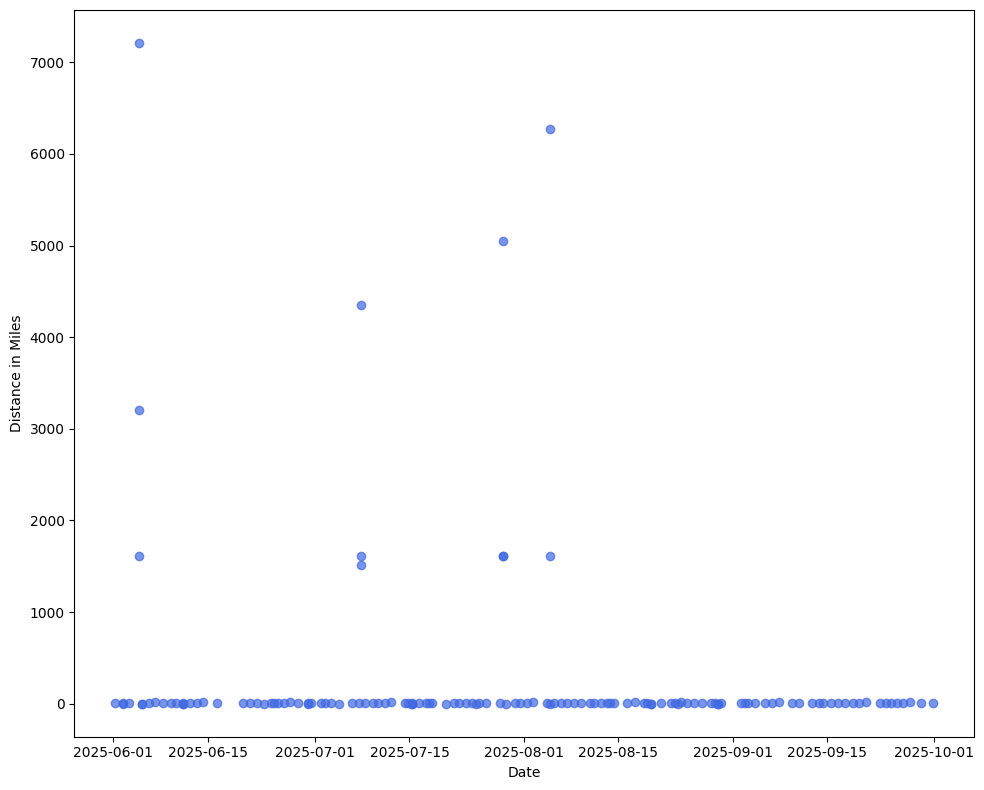

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(data["Date"], data["Distance"], alpha=0.7, color="royalblue")
plt.xlabel("Date")
plt.ylabel("Distance in Miles")
plt.tight_layout()


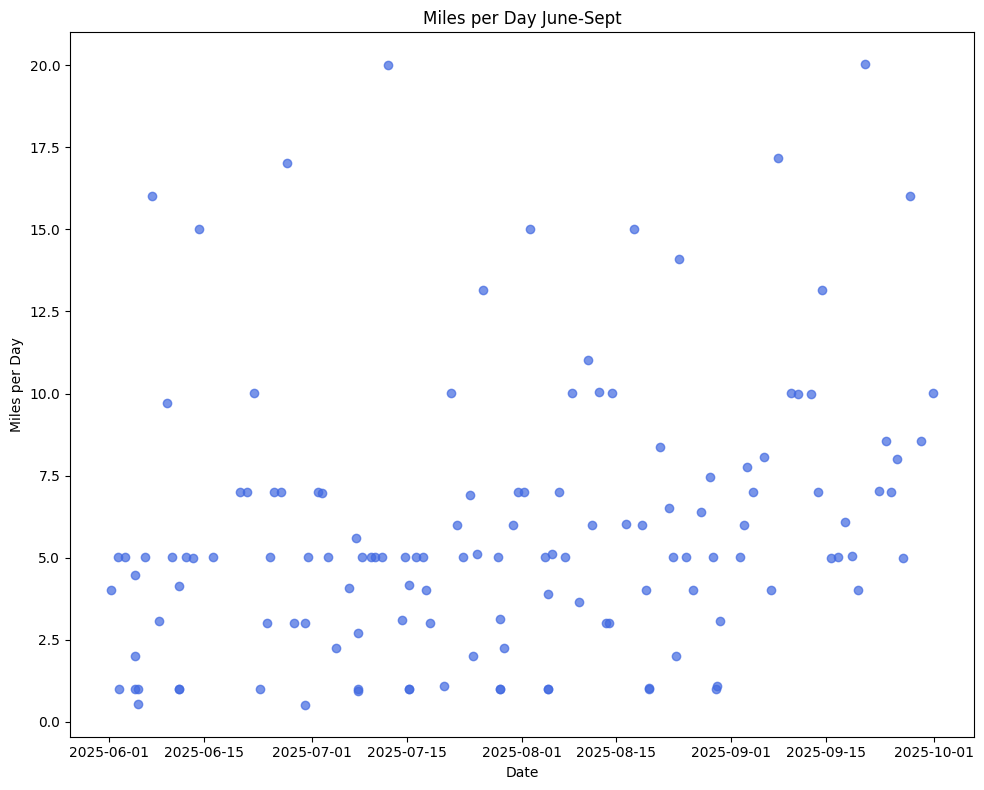

In [206]:
# Realize we have unrealistic values because some of the activites were done in meters because of the track workouts
data["Distance"].sort_values(ascending=False).head(10)
#data.loc[rows_to_change, columns_to_change] = new_value
data.loc[data["Distance"] > 100, "Distance"] = round(data["Distance"] / 1609.34, 2)

#Replot now
plt.figure(figsize=(10,8))
plt.scatter(data["Date"], data["Distance"], alpha=0.7, color="royalblue")
plt.title("Miles per Day June-Sept")
plt.xlabel("Date")
plt.ylabel("Miles per Day")
plt.tight_layout()





/var/folders/z5/sl5m8j4x253fdkftjccg38tw0000gn/T/ipykernel_25347/2170903246.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  miles_by_month = data.groupby("Month", sort=False)["Distance"].sum().sort_index()


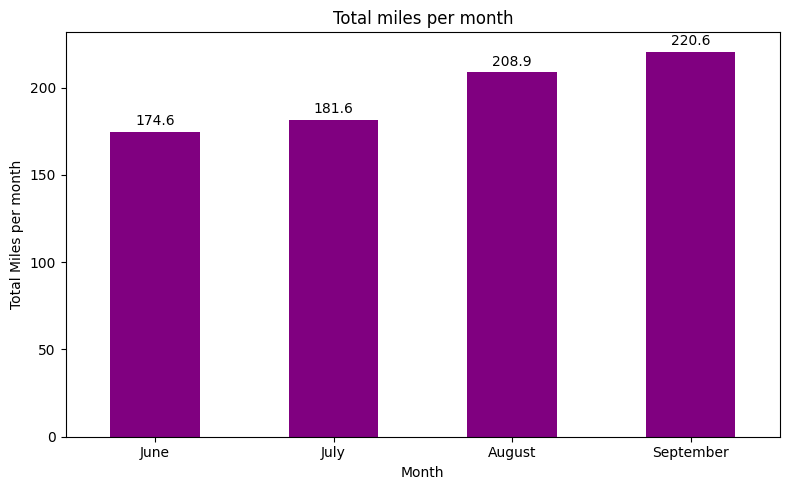

In [209]:
#Total Miles per month chart

data["Month"] = data["Date"].dt.month_name()

# I want the months to be in order so have to make it likes

months_ordered = ["January", "February", "March", "April", "May", "June",
         "July", "August", "September", "October", "November", "December"]

data["Month"] = pd.Categorical(data["Month"], ordered=True, categories=months_ordered)

miles_by_month = data.groupby("Month", sort=False)["Distance"].sum().sort_index()
miles_by_month = miles_by_month[miles_by_month > 0]

plt.figure(figsize=(8,5))
miles_by_month.plot(kind="bar", color="purple")
plt.title("Total miles per month")
plt.xlabel("Month")
plt.ylabel("Total Miles per month")
plt.xticks(rotation=0)

#Adding labels to each bar

for i, value in enumerate(miles_by_month):
    plt.text(
        x=i, #xpostion
        y=value + 2,  #yposition
        s=f"{value:.1f}", #text
        fontsize=10,
        ha="center",
        va="bottom",
        color="black"

    )

plt.tight_layout()
plt.show()

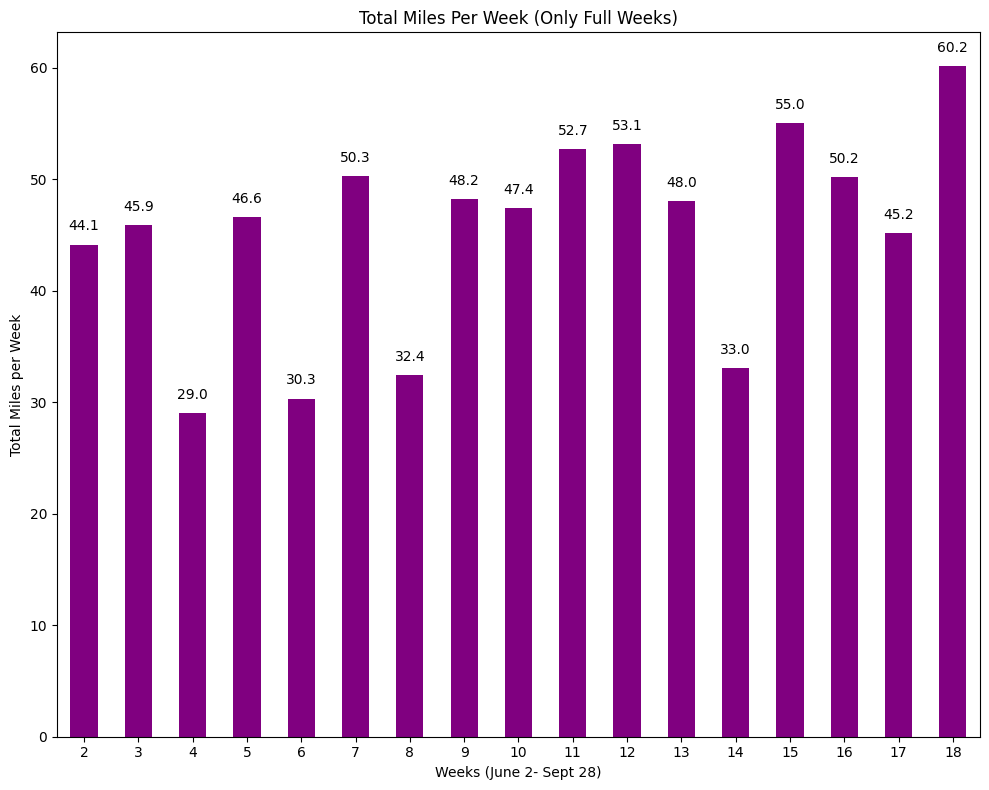

In [222]:
#Average Miles per Week by month

#Only full weeks included
miles_per_week = data.groupby("Week")["Distance"].sum()
miles_per_week = miles_per_week[miles_per_week > 20]

#Chart
plt.figure(figsize=(10,8))
miles_per_week.plot(kind="bar", color="purple")
plt.title("Total Miles Per Week (Only Full Weeks)")
plt.xlabel("Weeks (June 2- Sept 28)")
plt.ylabel("Total Miles per Week")
plt.xticks(rotation=0)

for i, value in enumerate(miles_per_week):
    plt.text(
        x=i,
        y=value + 1,
        s=f"{value:.1f}",
        fontsize=10,
        color="black",
        ha="center",
        va="bottom",
    )

plt.tight_layout()



/var/folders/z5/sl5m8j4x253fdkftjccg38tw0000gn/T/ipykernel_25347/2919718042.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pace_range = data.groupby("Distance Ranges")["Avg Pace"].mean().round(2)


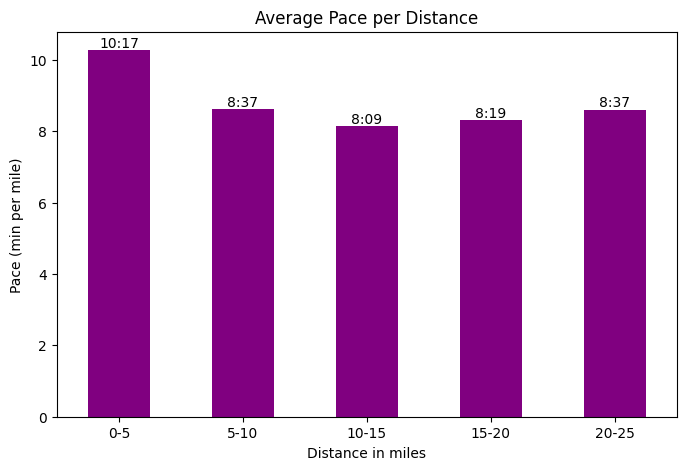

In [235]:
#Cutting data into Bins

bins = [0,5,10,15,20,25]
labels = ["0-5", "5-10", "10-15", "15-20", "20-25"]

data["Distance Ranges"] = pd.cut(data["Distance"], bins=bins, labels=labels, right=False)
avg_pace_range = data.groupby("Distance Ranges")["Avg Pace"].mean().round(2)

#Make chart now

plt.figure(figsize=(8,5))
avg_pace_range.plot(kind="bar",color="purple")
plt.title("Average Pace per Distance")
plt.xlabel("Distance in miles")
plt.ylabel("Pace (min per mile)")
plt.xticks(rotation=0)

#pace is going to be a float value
def float_to_pace(pace):
    m = int(pace)
    s= round((pace -m)*60)
    if s == 60:
        m += 1
        s = 0

    return f"{m}:{s:02d}"  

for i, value in enumerate(avg_pace_range):
    plt.text(
        x=i,
        y=value,
        s=float_to_pace(value),
        ha="center",
        va="bottom",
        fontsize="10",
        color="black"
    )

/var/folders/z5/sl5m8j4x253fdkftjccg38tw0000gn/T/ipykernel_25347/1485027977.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pace_per_zone = data.groupby("Zones")["Avg Pace"].mean().round(2)


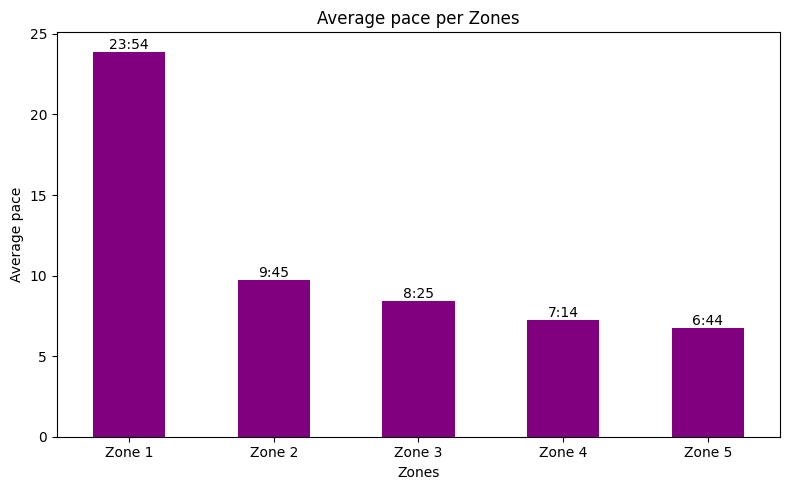

In [239]:
#Going to split up into zones now

#Zone 1 0-120
#Zone 2 120-145
#Zone 3 145-160
#Zone 4 160-175
#Zone 5 175+

zone_bins = [0,120,145,160,175,200]
zone_labels = ["Zone 1", "Zone 2", "Zone 3", "Zone 4", "Zone 5"]

data["Zones"] = pd.cut(data["Avg HR"], bins=zone_bins, labels=zone_labels, right=False)
pace_per_zone = data.groupby("Zones")["Avg Pace"].mean().round(2)
 

#Chart
plt.figure(figsize=(8,5))
pace_per_zone.plot(kind="bar", color="purple")
plt.title("Average pace per Zones")
plt.xlabel("Zones")
plt.ylabel("Average pace")
plt.xticks(rotation=0)
plt.tight_layout()

for i, value in enumerate(pace_per_zone):
    plt.text(
        x=i,
        y=value,
        s=float_to_pace(value),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"  
    )

